For this notebook, I utilize DCGAN to generate digits using the MNIST dataset for training.

### Imports

In [ ]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers
import time
from tqdm import tqdm

### DCGAN model

In [ ]:
IMAGE_SIZE = 64
BATCH_SIZE = 256
nz = 100 # Dimension of uniform distribution of random noise z
nc =   1 # Number of channels in output

#### Generator

In [ ]:
def make_generator():
  model = tf.keras.Sequential()

  model.add(layers.Dense(7*7*512, use_bias=False, input_shape=(nz,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Reshape((7, 7, 512)))
  assert model.output_shape == (None, 7, 7, 512)

  model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 256)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, nc)

  return model 

In [ ]:
generator = make_generator()

Weights should be initialized from a zero-centered Normal distribution with standard deviation of 0.02, for both the generator and discriminator.

In [ ]:
def init_weights(model):
  for layer in model.layers:
    try:
      layer.set_weights(tf.random.normal(shape=layer.get_weights()[0].shape, mean=0.0, stddev=0.02))
    except:
      continue

In [ ]:
init_weights(generator)

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [ ]:
generated_image.shape

TensorShape([1, 28, 28, 1])

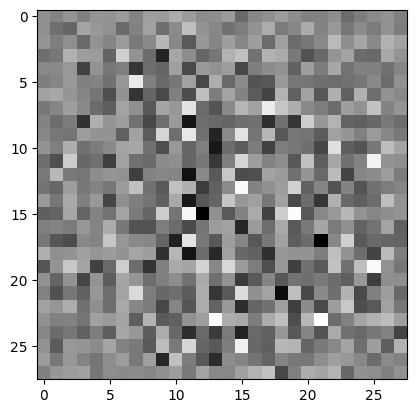

In [ ]:
plt.imshow(generated_image[0,:,:,0], cmap='gray')

#### Discriminator

In [ ]:
def make_discriminator():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                    input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model 

In [ ]:
discriminator = make_discriminator()
init_weights(discriminator)

In [ ]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00054062]], shape=(1, 1), dtype=float32)


#### Loss functions and optimizers

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

##### Discriminator loss

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

##### Generator loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

##### Training loop

In [ ]:
checkpoint_dir = 'drive/MyDrive/Colab Notebooks/Projects/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
num_examples = 16

seed = tf.random.normal([num_examples, nz])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, nz])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return (gen_loss, disc_loss)

In [ ]:
from IPython import display

In [ ]:
def train(dataset, epochs):
  gen_loss_history = []
  disc_loss_history = []

  for epoch in range(epochs):
    gen_epoch_loss = 0
    dis_epoch_loss = 0
    start = time.time()
    print(f'Epoch: {epoch}')

    for image_batch in tqdm(dataset):
      (gen_loss, disc_loss) = train_step(image_batch)
      gen_epoch_loss += gen_loss
      dis_epoch_loss += disc_loss

    gen_epoch_loss /= len(dataset)
    dis_epoch_loss /= len(dataset)

    gen_loss_history.append(gen_epoch_loss)
    disc_loss_history.append(dis_epoch_loss)

    # Produce images for GIF along the way
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print(f'Time for epoch {epoch+1} is {time.time()-start} seconds')
    print(f'Generator loss: {gen_epoch_loss:.4f} Discriminator loss: {dis_epoch_loss:.4f}')

  # Generator after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

  return (gen_loss_history, disc_loss_history)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(6, 6))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i,:,:,0]*127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('drive/MyDrive/Colab Notebooks/Projects/gifs/' + 'image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
import scipy
import numpy as np

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize images to [-1, 1]

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE)

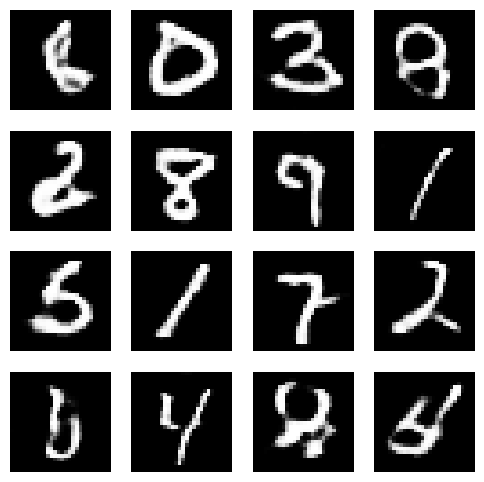

In [ ]:
EPOCHS = 100
(gen_loss_history, disc_loss_history) = train(train_dataset, EPOCHS)

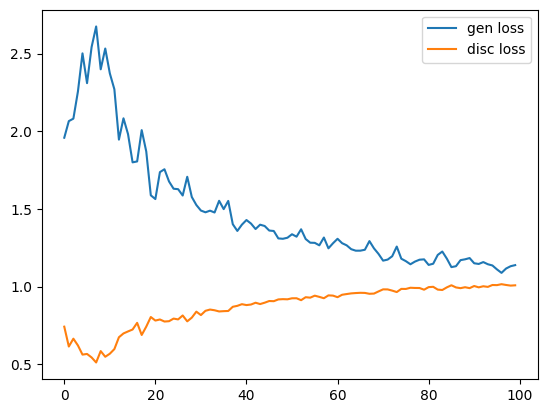

In [ ]:
plt.plot(gen_loss_history, label='gen loss')
plt.plot(disc_loss_history, label='disc loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-9odhgwc3
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-9odhgwc3
  Resolved https://github.com/tensorflow/docs to commit abfbe6e54864baa38dbb985b984acd304be610d4
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=183273 sha256=f5bbf881364ffa9e20037396ce4d3ee77ccf2512e8915c17bfb4c7c6b172bb2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-5l_g60ij/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
import glob
import imageio

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer: 
  filenames = glob.glob('drive/MyDrive/Colab Notebooks/Projects/gifs/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename) 
  writer.append_data(image)

<ipython-input-4-b7803816a4ca>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-4-b7803816a4ca>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



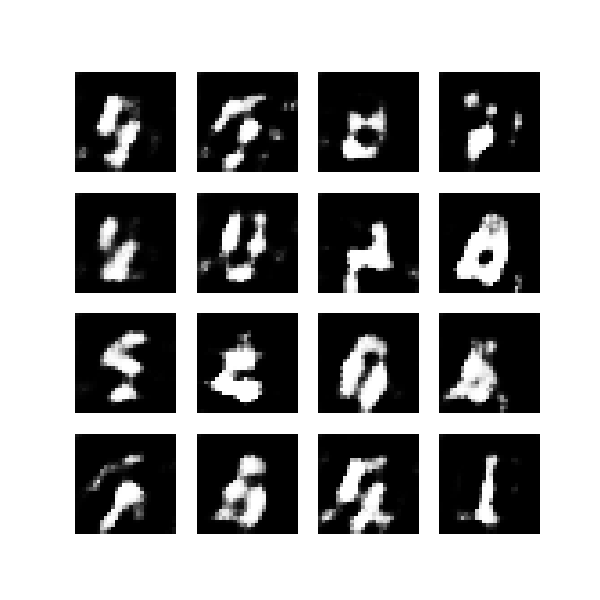

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)